----------------------------------------------------
# **Introduction to Optimization - Project.**
----------------------------------------------------

***************************************************************************
# **In this notebook we will run a number of regression models on our data and see if we can predict the run time and draw conclusions from it.**
***************************************************************************


In [ ]:
# Import the standard libraries of pandas.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings. filterwarnings("ignore")
sns.set_style('whitegrid')

In [ ]:
# Neaded for opening data file in drive.

from google.colab import files
uploaded = files.upload()
import io

Saving data_10000_clean.csv to data_10000_clean (2).csv


# **The data has the next featurs:**
* **Mean** - Average weights of the distance matrix.
* **Std** - Standard Deviation of the distance matrix.
* **Skewness** - What is the tendency of the weights in the distance matrix.
* **Noc** - Number of cities we have in the distance matrix [matrix dimension].
* **Td** - The total distance of the solution rout.
* **Dmft** - Distance matrix features time, That is how long it took us to calculate all these features.
* **MST_Mean** - Average weights of the MST.
* **MST_Std** - Standard Deviation of the MST.
* **MST_Skewness** - What is the tendency of the weights in the MST.
* **MST_ft** - MST features time, That is how long it took us to calculate the MST & all these features.
* **D_Mean** - Average degree of the MST.
* **D_Std** - Standard Deviation of the MST degrees.
* **D_Skewness** - What is the tendency of the degrees in the MST.
* **DFT_Mean** - The average weight of the deepest track in MST.
* **DFT_Std** - Standard Deviation of the deepest track in MST.
* **DFT_Max** - The heaviest arch on the longest route in MST.
* **DDFT_ft** - Degree & DFT features time, That is how long it took us to calculate all these features.

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['data_10000_clean.csv']))
try:
    df.drop(['Unnamed: 0'], axis=1, inplace=True) 
except: 
    pass
df.head()

,DDFT_ft,DFT_Max,DFT_Mean,DFT_Std,D_Mean,D_Skewness,D_Std,Dmft,MST_Mean,MST_Skewness,MST_Std,MST_ft,Mean,Noc,Skewness,Solution_time,Std,Td
0,0.002684,994.0,4.281241,53.119427,1.983051,0.991500,1.132149,0.004528,0.079216,17.508554,1.068120,0.005651,503.054007,118.0,-0.039861,0.269456,292.236114,2616.0
1,0.004046,997.0,2.391274,39.626311,1.990148,1.196133,1.067013,0.010491,0.031838,21.608326,0.541832,0.013047,500.059453,203.0,-0.014632,1.373102,289.733257,3185.0
2,0.006801,994.0,1.732715,34.118103,1.993127,0.854827,1.003419,0.020711,0.016698,31.544559,0.363748,0.029591,499.979240,291.0,-0.010912,2.116377,288.761128,3643.0
3,0.007278,995.0,1.592935,32.389269,1.993528,1.213399,1.122363,0.023446,0.013615,30.368070,0.297845,0.033800,498.676407,309.0,0.003925,2.001439,290.388494,3714.0
4,0.006666,999.0,1.688561,33.446180,1.993220,1.417943,1.121810,0.021590,0.014318,28.048382,0.302933,0.027265,496.423625,295.0,0.012855,2.972457,289.502941,3534.0


--------------------------------------------------
##**Divide the data into train set & test set.**
--------------------------------------------------

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data to training set and test set (70%, 30%)
features = list(df.drop('Solution_time', axis = 1, inplace = False))
y = df['Solution_time']
X = df[features]
#y = np.log(df['Solution_time'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

-----------------------------------------------------------------------
## **Use regression models to predicted with solution run time.**
-----------------------------------------------------------------------

In [ ]:
# Import models which we predicted with tham the solution, 
# And scoring methods to evaluate these models.

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
!pip3 install xgboost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
!pip install scikit-plot
import scikitplot as skplt
import matplotlib as mpl

In [ ]:
########################################## Several functions for different regression  models. ##########################################

class Score:

    r2 = 0.0                   # This score determines how close the predictions really are to the real data.
    cross_vali_score = 0.0     # How true is our algorithm if it going to well predict new data.

class Regressor:

    def __init__(self, name):
        self.name = name
        self.score = Score()
        self.y_pred = None
        self.reg = None

# Map between the name of a model and the model itself.
models_map = {'Random Forest': RandomForestRegressor(), 'Xgboost': XGBRegressor(), 'Ridge': Ridge(), 
              'Kneighbors': KNeighborsRegressor(), 'Linear Regressor': linear_model.LinearRegression()}

# This function return a map that maps between each model and its Regressor class.
def get_models():
    result_map = {}
    for key, val in models_map.items():
        result = Regressor(key)
        reg = val
        result.score.cross_vali_score = np.mean(cross_val_score(reg, X_train, y_train, cv=5))        
        result.reg = reg.fit(X_train, y_train) 
        result.y_pred = reg.predict(X_test) 
        result.score.r2 = r2_score(y_test, result.y_pred) 
        result_map[key] = result 
    return result_map

# This function print a graph for models of the features that influenced their decision making.
def print_influence_graph(map):
    for key, val in map.items():
        if key == 'Random Forest' or key == 'Xgboost':
            # The parameters that most influenced the decision.
            feature_imp = pd.Series(val.reg.feature_importances_,index=features).sort_values(ascending=False)
            sns.barplot(x=feature_imp, y=feature_imp.index)
            # Add labels to your graph
            plt.xlabel('Feature Importance Score')
            plt.ylabel('Features')
            plt.title(val.name.upper() +" - Visualizing Important Features")
            plt.show()

# This function print a graph for models that show the real results against the model predictions.
def show_predicted_vs_actual(map):
    for key, val in map.items():
        fig, ax = plt.subplots()
        ax.scatter(y_test, val.y_pred, edgecolors=(0, 0, 1))
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.title.set_text(val.name.upper() +" - Predicted time vs actual time")
        plt.show()

# This function print numerical scores for the models.
def print_scores(map):
    for key, val in map.items():
        print(val.name.upper() + ' SCORE: ')
        print('R2score' + '  =  ', val.score.r2)
        print('Cross_val_score' + '  =  ', val.score.cross_vali_score)
        print('------------------------------------------\n')

# This function print a graph showing the differences between the scores of the models.
def show_models_differences_graph(map):
    comp_df = pd.DataFrame(columns = ('Method', 'R2 Score', 'Cross val score'))
    for i in map:
        row = {'Method': i, 'R2 Score': map[i].score.r2, 'Cross val score': map[i].score.cross_vali_score}
        comp_df = comp_df.append(row, ignore_index=True)
    ax = comp_df.plot.bar(x='Method', rot=30, figsize=(12,6))
    ax.set_title('Comparison graph')   
#########################################################################################################################################

In [ ]:
models = get_models()

[17:26:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


---------------------------------------------------------
#**Show influence graphs.**
For models that have this feature.

---------------------------------------------------------

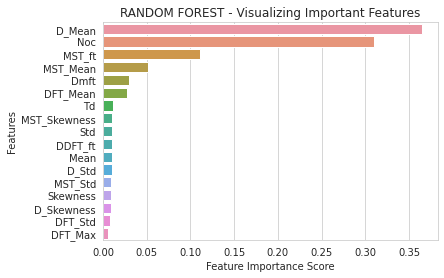

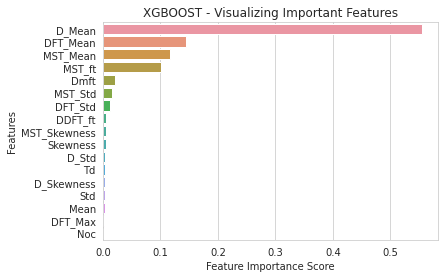

In [ ]:
print_influence_graph(models)

---------------------------------------------------------
#**Show predicted vs actual graphs.**
---------------------------------------------------------

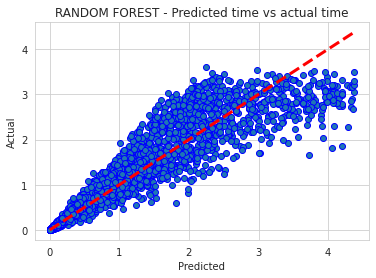

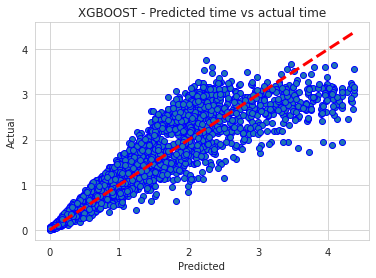

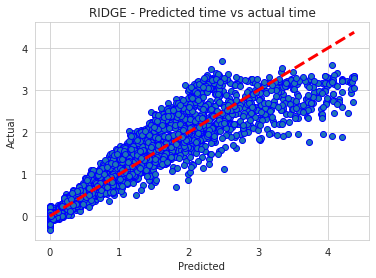

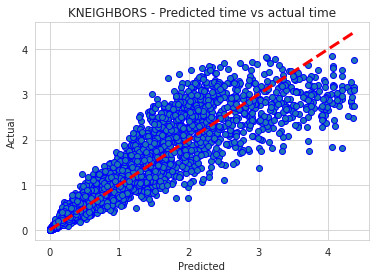

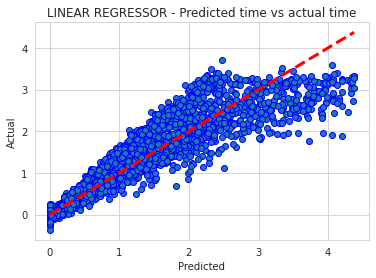

In [ ]:
show_predicted_vs_actual(models)

---------------------------------------------------------
#**Print the scores of each model.**
---------------------------------------------------------

In [ ]:
print_scores(models)

RANDOM FOREST SCORE: 
R2score  =   0.8437243656299124
Cross_val_score  =   0.8491071235471722
------------------------------------------

XGBOOST SCORE: 
R2score  =   0.8498740372867254
Cross_val_score  =   0.8558922075226734
------------------------------------------

RIDGE SCORE: 
R2score  =   0.8526055849865555
Cross_val_score  =   0.8556286146392486
------------------------------------------

KNEIGHBORS SCORE: 
R2score  =   0.8213143697981684
Cross_val_score  =   0.8268795033204593
------------------------------------------

LINEAR REGRESSOR SCORE: 
R2score  =   0.8525779676108073
Cross_val_score  =   0.855612739025221
------------------------------------------



---------------------------------------------------------
#**Show the differences between the models in a graph.**
---------------------------------------------------------

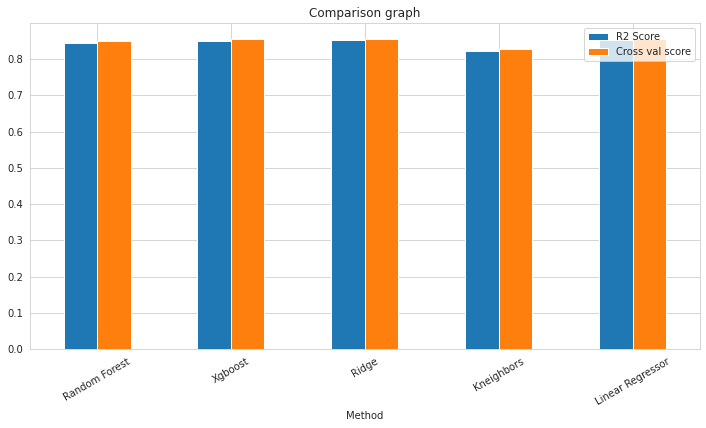

In [ ]:
show_models_differences_graph(models)